In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pix2pix-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F34683%2F47283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240703%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240703T121808Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da4c2615e76ced46e96738d0c2b3b7390bb91c503fa9f405dd0c4b6a001d5743d3d1cc1bce72e8100374809c64ea85fe2bd4babf9907d7b06f85f2c09389ffde769123a17ea8bf71b42e7174e65264e6acec414776150b90ea9ac38b6b6447c1dbe3b4ba3041dd1583292bd846c4a0aadf1b3ef244cccb123faabf01b90960b45a13565a4b7c142f7263898cc9f3aa7a05932a9ff638b6f17bd60306da689399963cd5d249e51bcb4a49017212d9cada7a19c3a0d24d7d60ea48545cc69ab9c28540b8ac85ba6ac7922478e6b5555c03d60eb382a51aeee6078c1af27c88c55ab3b7dcaec930b04fb82141d2d9921b059e4eac3a14311e0f31ee4c92b7bf31ec4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2574957257 bytes downloaded
Downloaded and uncompressed: pix2pix-dataset
Data source import complete.


In [2]:
import torch
import torch.nn as nn


In [3]:
class convblock(nn.Module):
  def __init__(self, inc, out, stride=2):
    super().__init__()

    self.conv=nn.Sequential(
        nn.Conv2d(inc,out,4,stride,bias=False,padding_mode='reflect'),
        nn.BatchNorm2d(out),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.conv(x)

class Discriminator(nn.Module):
  def __init__(self, inc=3,features=[64,128,256,512]):
    super().__init__()
    self.intl=nn.Sequential(
        nn.Conv2d(inc*2,features[0],kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    )

    self.layers= [convblock(features[fnum-1],features[fnum],stride=1) if (fnum== len(features)-1) else convblock(features[fnum-1],features[fnum]) for fnum in range(1,len(features))]

    self.layers.append(
        nn.Conv2d(features[-1],1,kernel_size=4,stride=1,padding=1,padding_mode="reflect")
    )
    self.model=nn.Sequential(*self.layers)

  def forward(self, x, y):
    x=torch.cat([x, y] ,dim=1)
    x=self.intl(x)

    return self.model(x)



In [4]:
model=Discriminator()
x=torch.randn(1,3,256,256)
y=torch.randn(1,3,256,256)
print(model(x,y).shape)

torch.Size([1, 1, 26, 26])


In [5]:
class Gconvblock(nn.Module):
  def __init__(self, inc,out,down=True,relu=True,drop=True) -> None:
     super().__init__()

     self.cnn=nn.Sequential(
         nn.Conv2d(inc,out,4,2,1,bias=False,padding_mode='reflect')
         if down else nn.ConvTranspose2d(inc,out,4,2,1,bias=False),
         nn.BatchNorm2d(out),
         nn.ReLU() if relu else nn.LeakyReLU(0.2),
     )

     self.drop=drop
     self.dropout=nn.Dropout(0.5)

  def forward(self, x):
    x=self.cnn(x)
    return self.dropout(x) if self.drop else x

class Generator(nn.Module):
  def __init__(self, inc, features=64):
    super().__init__()
    self.intg=nn.Sequential(
        nn.Conv2d(inc,features,4,2,1,padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    )

    self.down1=Gconvblock(features,features*2,relu=False,drop=False)
    self.down2=Gconvblock(features*2,features*4,relu=False,drop=False)
    self.down3=Gconvblock(features*4,features*8,relu=False,drop=False)
    self.down4=Gconvblock(features*8,features*8,relu=False,drop=False)
    self.down5=Gconvblock(features*8,features*8,relu=False,drop=False)
    self.down6=Gconvblock(features*8,features*8,relu=False,drop=False)

    self.bottleneck=nn.Sequential(
        nn.Conv2d(features*8,features*8,4,2,1,padding_mode="reflect"),
        nn.ReLU(),
    )

    self.up1=Gconvblock(features*8,features*8,down=False)
    self.up2=Gconvblock(features*8*2,features*8,down=False)
    self.up3=Gconvblock(features*8*2,features*8,down=False)
    self.up4=Gconvblock(features*8*2,features*8,down=False)
    self.up5=Gconvblock(features*8*2,features*4,down=False)
    self.up6=Gconvblock(features*4*2,features*2,down=False)
    self.up7=Gconvblock(features*2*2,features,down=False)

    self.out=nn.Sequential(
        nn.ConvTranspose2d(features*2,inc,4,2,1),
        nn.Tanh()
    )

  def forward(self, x):
        d1 = self.intg(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.out(torch.cat([up7, d1], 1))

In [6]:
mogd=Generator(3)
x=torch.randn(1,3,256,256)
print(mogd(x).shape)

torch.Size([1, 3, 256, 256])


In [7]:
datapath="/kaggle/input/pix2pix-dataset/maps/maps"

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform_both = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_input = A.Compose(
    [

        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [9]:
from torch.utils.data import Dataset
import os
import numpy as np
from PIL import Image

class Mapdata(Dataset):
  def __init__(self,rootdir):
    self.rootdir=rootdir
    self.files=os.listdir(self.rootdir)


  def __len__(self):
    return len(self.files)

  def __getitem__(self, index) :

    img0=Image.open(os.path.join(self.rootdir,self.files[index]))
    image=np.array(img0)[:,:600,:]
    target=np.array(img0)[:,600:,:]

    augmentations = transform_both(image=image, image0=target)
    input_image = augmentations["image"]
    target_image = augmentations["image0"]

    input_image = transform_input(image=input_image)["image"]
    target_image = transform_mask(image=target_image)["image"]

    return input_image,target_image

In [10]:
traindata=Mapdata(datapath+"/train")
valdata=Mapdata(datapath+"/val")

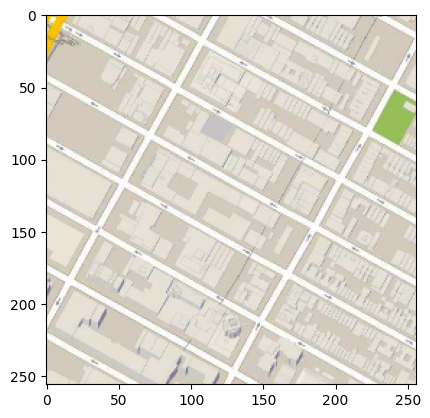

In [11]:
from matplotlib import pyplot as plt
plt.imshow(traindata[1][1].permute(1, 2, 0))

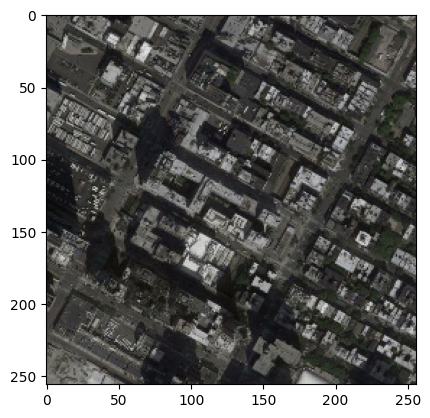

In [12]:
plt.imshow((traindata[1][0]*0.5 +0.5).permute(1, 2, 0))

In [13]:
epochs=100
lr=2e-4
num_workers=2
L1_lambda= 100
device= "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True


In [24]:
from torch.utils.data import DataLoader
trainloader=DataLoader(traindata,batch_size=16,shuffle=True,num_workers=num_workers)
valloader=DataLoader(valdata,batch_size=16,shuffle=False,num_workers=num_workers)


In [23]:
def weights_init(m):
    name = m.__class__.__name__

    if(name.find("Conv") > -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02) # ~N(mean=0.0, std=0.02)
    elif(name.find("BatchNorm") > -1):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [31]:
from tqdm import tqdm
def train(disc,gen,trainloader,epochs=100):
  disc=disc.to(device)
  gen=gen.to(device)




  disc.train()
  gen.train()

  opt_disc=torch.optim.Adam(disc.parameters(),lr=lr,betas=(0.5,0.999))
  opt_gen=torch.optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.999))

  bce=nn.BCEWithLogitsLoss()
  l1=nn.L1Loss()

  dscaler=torch.cuda.amp.GradScaler()
  gscaler=torch.cuda.amp.GradScaler()

  for epoch in range(epochs):
    loop= tqdm(enumerate(trainloader),total=len(trainloader))
    glossavg=0
    dlossavg=0
    for i,(x,y) in loop:
      x=x.to(device)
      y=y.to(device)

      with torch.cuda.amp.autocast():
        y_fake=gen(x)
        real_dis=disc(x,y)
        disc_realloss=bce(real_dis,torch.ones_like(real_dis))
        fake_dis=disc(x,y_fake)
        disc_fakeloss=bce(fake_dis,torch.zeros_like(fake_dis))
        disc_loss=(disc_realloss+disc_fakeloss)/2
        dlossavg+=disc_loss.item()

      opt_disc.zero_grad()
      dscaler.scale(disc_loss).backward(retain_graph=True)
      dscaler.step(opt_disc )
      dscaler.update()


      with torch.cuda.amp.autocast():
          D_fake = disc(x, y_fake)
          G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
          L1 = l1(y_fake, y) * L1_lambda
          G_loss = G_fake_loss + L1
          glossavg+=G_loss.item()

      opt_gen.zero_grad()

      gscaler.scale(G_loss).backward()
      gscaler.step(opt_gen)
      gscaler.update()

      if i==len(trainloader)-1:
        print(epoch)
        print(dlossavg/(len(trainloader)))
        print(glossavg/(len(trainloader)))
      if i % 10 == 0:
            loop.set_postfix(
                genloss=G_loss.item(),
                discloss=disc_loss.item(),
            )





In [32]:
disc = Discriminator(inc=3).to(device)
gen = Generator(inc=3, features=64).to(device)
disc.apply(weights_init)
gen.apply(weights_init)

Generator(
  (intg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Gconvblock(
    (cnn): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Gconvblock(
    (cnn): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Gconvblock(
    (cnn): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

In [41]:
train(disc,gen,trainloader,epochs=100)

100%|██████████| 69/69 [00:17<00:00,  3.92it/s, discloss=0.122, genloss=12]

0
0.19517835677749867
11.170967848404594



100%|██████████| 69/69 [00:17<00:00,  4.02it/s, discloss=0.0147, genloss=11.9]

1
0.06552612249725971
11.661394713581473



100%|██████████| 69/69 [00:17<00:00,  3.99it/s, discloss=0.142, genloss=9.08]

2
0.22773469201680543
11.595825741256492



100%|██████████| 69/69 [00:16<00:00,  4.10it/s, discloss=0.0284, genloss=11.5]

3
0.0413938670999546
11.6435934426128



100%|██████████| 69/69 [00:16<00:00,  4.10it/s, discloss=0.0336, genloss=10.8]

4
0.17113981748917612
11.428604637367139



100%|██████████| 69/69 [00:17<00:00,  4.04it/s, discloss=0.0607, genloss=11.8]

5
0.0637104208783611
11.946287431578705



100%|██████████| 69/69 [00:17<00:00,  4.05it/s, discloss=0.0328, genloss=11.8]

6
0.20494820466400057
11.17071028723233



100%|██████████| 69/69 [00:16<00:00,  4.07it/s, discloss=0.125, genloss=12]

7
0.10025069939539484
11.742112387781559



100%|██████████| 69/69 [00:17<00:00,  3.99it/s, discloss=0.0225, genloss=12.6]

8
0.053819017673748124
12.349888684093088



100%|██████████| 69/69 [00:17<00:00,  4.01it/s, discloss=0.0728, genloss=11.3]

9
0.19875140884972137
11.498988718226336



100%|██████████| 69/69 [00:16<00:00,  4.06it/s, discloss=0.0115, genloss=11.8]

10
0.15010302013083213
11.573273658752441



100%|██████████| 69/69 [00:16<00:00,  4.13it/s, discloss=0.0234, genloss=13.5]

11
0.067076258374837
12.12998068159905



100%|██████████| 69/69 [00:16<00:00,  4.19it/s, discloss=0.0209, genloss=11.2]

12
0.046740027618648455
12.554109352222387



100%|██████████| 69/69 [00:16<00:00,  4.15it/s, discloss=0.139, genloss=14.3]

13
0.06019097263587342
12.901914154273877



100%|██████████| 69/69 [00:17<00:00,  4.04it/s, discloss=0.0827, genloss=9.79]

14
0.4226799217066255
10.321093365766



100%|██████████| 69/69 [00:16<00:00,  4.08it/s, discloss=0.00935, genloss=12.8]

15
0.041600711960885405
11.899112881093785



100%|██████████| 69/69 [00:16<00:00,  4.12it/s, discloss=0.153, genloss=10.4]

16
0.40350327230450034
9.75900277538576



100%|██████████| 69/69 [00:16<00:00,  4.14it/s, discloss=1.23, genloss=7.28]

17
0.21472965696475643
10.80720931896265



100%|██████████| 69/69 [00:16<00:00,  4.13it/s, discloss=0.0192, genloss=12.1]

18
0.1770019791615398
10.840220340784045



100%|██████████| 69/69 [00:16<00:00,  4.12it/s, discloss=0.0457, genloss=13.1]

19
0.02347990596815404
12.11381176934726



100%|██████████| 69/69 [00:16<00:00,  4.08it/s, discloss=0.168, genloss=12.3]

20
0.03632312118534701
12.805364608764648



100%|██████████| 69/69 [00:16<00:00,  4.10it/s, discloss=0.0274, genloss=12.9]

21
0.06615114441829854
12.180462505506432



100%|██████████| 69/69 [00:16<00:00,  4.17it/s, discloss=0.0289, genloss=12.2]

22
0.02616395123059983
12.624379724696063



100%|██████████| 69/69 [00:16<00:00,  4.13it/s, discloss=0.0242, genloss=11.3]

23
0.18068520303653635
11.37734904496566



100%|██████████| 69/69 [00:17<00:00,  4.04it/s, discloss=0.389, genloss=8.85]

24
0.26736908753578
11.186888611834982



100%|██████████| 69/69 [00:16<00:00,  4.07it/s, discloss=0.0216, genloss=11.3]

25
0.08849395252764225
11.393745104471842



100%|██████████| 69/69 [00:16<00:00,  4.10it/s, discloss=0.0193, genloss=12.3]

26
0.038805167102997286
12.499641142029693



100%|██████████| 69/69 [00:16<00:00,  4.11it/s, discloss=0.0109, genloss=12.6]

27
0.1535357663853337
11.458139004914656



100%|██████████| 69/69 [00:16<00:00,  4.15it/s, discloss=0.0176, genloss=11.1]

28
0.18554754094288184
11.574961931809135



100%|██████████| 69/69 [00:16<00:00,  4.12it/s, discloss=0.0176, genloss=12]

29
0.0407705212254887
11.936457772185838



100%|██████████| 69/69 [00:16<00:00,  4.11it/s, discloss=0.228, genloss=10.4]

30
0.2864612895975132
11.444690303526063



100%|██████████| 69/69 [00:16<00:00,  4.15it/s, discloss=0.0149, genloss=12]

31
0.07781550178196335
11.46022681913514



100%|██████████| 69/69 [00:16<00:00,  4.15it/s, discloss=0.0205, genloss=11.4]

32
0.0246911721398541
12.16706116994222



100%|██████████| 69/69 [00:16<00:00,  4.12it/s, discloss=0.0552, genloss=14.2]

33
0.015619504623169052
12.863905118859332



100%|██████████| 69/69 [00:16<00:00,  4.07it/s, discloss=0.153, genloss=10.3]

34
0.18005776985892621
12.462610348411229



100%|██████████| 69/69 [00:16<00:00,  4.13it/s, discloss=0.0335, genloss=12.6]

35
0.1392402494110275
11.388594033061594



100%|██████████| 69/69 [00:16<00:00,  4.06it/s, discloss=0.0525, genloss=14.6]

36
0.10314529819036092
11.775216482687688



100%|██████████| 69/69 [00:17<00:00,  4.03it/s, discloss=0.0235, genloss=12.1]

37
0.07789613630291939
11.876822084620379



100%|██████████| 69/69 [00:17<00:00,  4.01it/s, discloss=0.065, genloss=8.6]

38
0.5154173202353759
9.78862344354823



100%|██████████| 69/69 [00:17<00:00,  4.03it/s, discloss=0.0192, genloss=11.4]

39
0.1252365578910795
10.807317180909973



100%|██████████| 69/69 [00:17<00:00,  4.03it/s, discloss=0.00259, genloss=13.1]

40
0.021020833119426086
11.934607257013736



100%|██████████| 69/69 [00:16<00:00,  4.12it/s, discloss=0.0184, genloss=12.1]

41
0.022407324971172256
12.673152605692545



100%|██████████| 69/69 [00:16<00:00,  4.12it/s, discloss=0.0186, genloss=13.7]

42
0.02791658781495863
12.907575123551963



100%|██████████| 69/69 [00:16<00:00,  4.09it/s, discloss=0.0125, genloss=15.1]

43
0.11040984825703545
12.088868258655936



100%|██████████| 69/69 [00:16<00:00,  4.19it/s, discloss=0.0244, genloss=13]

44
0.01857095864344982
12.885998933211617



100%|██████████| 69/69 [00:16<00:00,  4.09it/s, discloss=0.0276, genloss=13.1]

45
0.013111659725520598
13.237592945928158



100%|██████████| 69/69 [00:17<00:00,  4.04it/s, discloss=0.399, genloss=9.39]

46
0.17300410257935847
12.973701352658479



100%|██████████| 69/69 [00:16<00:00,  4.11it/s, discloss=0.269, genloss=10.6]

47
0.20556599795278432
11.4072091061136



100%|██████████| 69/69 [00:16<00:00,  4.15it/s, discloss=0.108, genloss=10.5]

48
0.18684480232659026
10.888879312985186



100%|██████████| 69/69 [00:16<00:00,  4.09it/s, discloss=0.0112, genloss=12.9]

49
0.07453456069545253
11.772794308869734



100%|██████████| 69/69 [00:16<00:00,  4.09it/s, discloss=0.043, genloss=10.8]

50
0.18137310283339542
10.827055903448574



100%|██████████| 69/69 [00:16<00:00,  4.12it/s, discloss=0.0157, genloss=11.4]

51
0.07182511571200861
11.940031120742576



100%|██████████| 69/69 [00:16<00:00,  4.07it/s, discloss=0.123, genloss=10.7]

52
0.08404784332420948
12.13194421408833



100%|██████████| 69/69 [00:16<00:00,  4.17it/s, discloss=0.00259, genloss=13.4]

53
0.016873948103950723
12.658208225084389



100%|██████████| 69/69 [00:16<00:00,  4.11it/s, discloss=0.0471, genloss=11.1]

54
0.2586307311093138
10.742220284282297



100%|██████████| 69/69 [00:16<00:00,  4.10it/s, discloss=0.566, genloss=9.81]

55
0.284928816843076
10.779700714608897



100%|██████████| 69/69 [00:16<00:00,  4.12it/s, discloss=0.00419, genloss=12.9]

56
0.05403330341062468
11.289342161537945



100%|██████████| 69/69 [00:16<00:00,  4.08it/s, discloss=0.0483, genloss=13.7]

57
0.031933412890530366
12.259499301081119



100%|██████████| 69/69 [00:16<00:00,  4.16it/s, discloss=0.00187, genloss=13.2]

58
0.014927872783922847
12.752671628758527



100%|██████████| 69/69 [00:16<00:00,  4.14it/s, discloss=0.0172, genloss=12.9]

59
0.021108077366606914
13.357902775640072



100%|██████████| 69/69 [00:16<00:00,  4.09it/s, discloss=0.311, genloss=10.2]

60
0.32112430735909636
11.054481699846793



100%|██████████| 69/69 [00:16<00:00,  4.11it/s, discloss=0.00948, genloss=11.4]

61
0.04873196132805036
11.715198876201242



100%|██████████| 69/69 [00:16<00:00,  4.14it/s, discloss=0.00406, genloss=13.2]

62
0.018301237276687785
12.48619748544002



100%|██████████| 69/69 [00:17<00:00,  4.03it/s, discloss=0.00604, genloss=14.6]

63
0.03243489380237525
12.553772622260494



100%|██████████| 69/69 [00:16<00:00,  4.07it/s, discloss=0.02, genloss=12.6]

64
0.018650819626771776
13.217254776885545



100%|██████████| 69/69 [00:17<00:00,  4.03it/s, discloss=0.00922, genloss=15.8]

65
0.01581557219227155
14.20943520034569



100%|██████████| 69/69 [00:16<00:00,  4.13it/s, discloss=0.00533, genloss=15]

66
0.014133774095039436
14.713516373565232



100%|██████████| 69/69 [00:20<00:00,  3.36it/s, discloss=0.00595, genloss=14.3]

67
0.1283119220296731
15.160066894862963



100%|██████████| 69/69 [00:18<00:00,  3.81it/s, discloss=1.5, genloss=8.81]

68
0.11270462259974169
14.161780260611271



100%|██████████| 69/69 [00:16<00:00,  4.17it/s, discloss=0.0685, genloss=11.1]

69
0.26832790591794514
11.02212765596915



100%|██████████| 69/69 [00:16<00:00,  4.16it/s, discloss=0.0384, genloss=11.2]

70
0.11336179714703905
11.726757961770762



100%|██████████| 69/69 [00:16<00:00,  4.11it/s, discloss=0.121, genloss=10.8]

71
0.1334235378122632
11.262281583703082



100%|██████████| 69/69 [00:16<00:00,  4.12it/s, discloss=0.00875, genloss=12.1]

72
0.2309865410696121
10.468335193136465



100%|██████████| 69/69 [00:17<00:00,  3.97it/s, discloss=0.00396, genloss=12.7]

73
0.04034684161129205
12.003649587216584



100%|██████████| 69/69 [00:17<00:00,  4.01it/s, discloss=0.00884, genloss=12.2]

74
0.015476073268328564
12.78031139097352



100%|██████████| 69/69 [00:17<00:00,  3.95it/s, discloss=0.0258, genloss=12.2]

75
0.014902919075330314
12.988648995109227



100%|██████████| 69/69 [00:17<00:00,  4.06it/s, discloss=0.02, genloss=12.8]

76
0.006620255356276597
13.561096702796826



100%|██████████| 69/69 [00:17<00:00,  3.88it/s, discloss=0.00107, genloss=16.1]

77
0.007663499806042545
13.855029506959777



100%|██████████| 69/69 [00:17<00:00,  4.01it/s, discloss=0.0267, genloss=12.7]

78
0.1685247579606358
12.318030993143717



100%|██████████| 69/69 [00:17<00:00,  4.02it/s, discloss=0.334, genloss=9.57]

79
0.2832224264072821
11.200682854306871



100%|██████████| 69/69 [00:17<00:00,  4.01it/s, discloss=0.0121, genloss=12.1]

80
0.03675625030545221
11.430271190145742



100%|██████████| 69/69 [00:16<00:00,  4.06it/s, discloss=0.0636, genloss=10.2]

81
0.5365164428949356
9.422253138777139



100%|██████████| 69/69 [00:16<00:00,  4.14it/s, discloss=0.0208, genloss=12.7]

82
0.12048671887242708
10.761930023414502



100%|██████████| 69/69 [00:17<00:00,  4.05it/s, discloss=0.0656, genloss=10.7]

83
0.026428998270800905
12.396732966105143



100%|██████████| 69/69 [00:16<00:00,  4.10it/s, discloss=0.0409, genloss=13.9]

84
0.007938459803235542
13.478313045225281



100%|██████████| 69/69 [00:17<00:00,  3.96it/s, discloss=0.00708, genloss=12.6]

85
0.010630243413987151
12.932118139405182



100%|██████████| 69/69 [00:17<00:00,  4.00it/s, discloss=0.00168, genloss=14.4]

86
0.005998957780716212
13.244813504426375



100%|██████████| 69/69 [00:17<00:00,  3.92it/s, discloss=0.432, genloss=10.5]

87
0.46213992754760047
10.464998846468719



100%|██████████| 69/69 [00:17<00:00,  3.99it/s, discloss=0.0353, genloss=11.9]

88
0.07272729256689764
11.066190823264744



100%|██████████| 69/69 [00:17<00:00,  3.94it/s, discloss=0.00362, genloss=13.3]

89
0.013443400592381216
12.47917852539947



100%|██████████| 69/69 [00:17<00:00,  3.99it/s, discloss=0.164, genloss=9.77]

90
0.05561589954954073
12.51068972159123



100%|██████████| 69/69 [00:17<00:00,  3.93it/s, discloss=0.0261, genloss=12.5]

91
0.014230715367349161
12.59131614021633



100%|██████████| 69/69 [00:18<00:00,  3.81it/s, discloss=0.00303, genloss=12.8]

92
0.010544675464768881
13.283668075782666



100%|██████████| 69/69 [00:17<00:00,  3.99it/s, discloss=0.0494, genloss=12.2]

93
0.3920534059027399
10.26590377005978



100%|██████████| 69/69 [00:17<00:00,  4.01it/s, discloss=0.0145, genloss=13.6]

94
0.06578532764958082
11.345813847970271



100%|██████████| 69/69 [00:17<00:00,  3.99it/s, discloss=0.0281, genloss=10.4]

95
0.15511213259879444
10.939357805943143



100%|██████████| 69/69 [00:17<00:00,  3.93it/s, discloss=0.0115, genloss=11.7]

96
0.02106164113038044
12.179218444271363



100%|██████████| 69/69 [00:17<00:00,  4.00it/s, discloss=0.00672, genloss=11.7]

97
0.05404575354338664
12.013791457466457



100%|██████████| 69/69 [00:17<00:00,  4.06it/s, discloss=0.229, genloss=10.9]

98
0.018349383475150968
12.954980601435123



100%|██████████| 69/69 [00:17<00:00,  4.03it/s, discloss=0.00263, genloss=13.3]

99
0.0060645253515626855
13.363616321397865


Text(0.5, 1.0, 'Real')

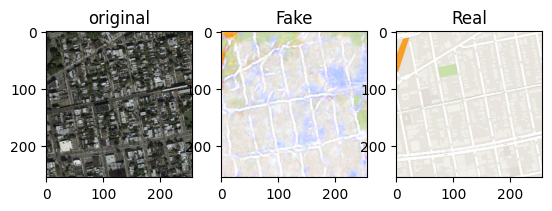

In [59]:
#test1
x=valdata[10][0].unsqueeze(0).to(device)
y=valdata[10][1].unsqueeze(0).to(device)
y_fake=gen(x)


plt.subplot(1,3,1)
plt.imshow((x*0.5 +0.5).cpu().detach().squeeze(0).permute(1, 2, 0).numpy())
plt.title("original")
plt.subplot(1,3,2)
plt.imshow((y_fake*0.5 +0.5).cpu().detach().squeeze(0).permute(1, 2, 0).numpy())
plt.title("Fake")
plt.subplot(1,3,3)
plt.imshow((y*0.5 +0.5).cpu().detach().squeeze(0).permute(1, 2, 0))
plt.title("Real")

In [50]:
torch.save(disc.state_dict(),'Discforpix2pix200ep.pth')
torch.save(gen.state_dict(),'genforpix2pix200ep.pth')

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
!cp genforpix2pix200ep.pth /content/drive/MyDrive

In [53]:
!cp Discforpix2pix200ep.pth /content/drive/MyDrive

In [55]:
from torchvision.utils import save_image
save_image((y_fake*0.5 +0.5),"abc.png")